# Image Forgery Detection


## State of the art models


In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from PIL import Image, ImageChops, ImageEnhance
import os 
import joblib
PATH_IMG = '../dataset/CASIA2/'

In [2]:
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH_IMG+label))
    for img_file in os.listdir(PATH_IMG+label):
        img_lst.append(PATH_IMG+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,../dataset/CASIA2/Au/Au_ani_00001.jpg,Au
1,../dataset/CASIA2/Au/Au_ani_00002.jpg,Au
2,../dataset/CASIA2/Au/Au_ani_00003.jpg,Au
3,../dataset/CASIA2/Au/Au_ani_00004.jpg,Au
4,../dataset/CASIA2/Au/Au_ani_00005.jpg,Au


### JPEG Compression


In [3]:
PATH_RESAVED = '../dataset/resaved/'

def resave(quality):
        
    for index, row  in df.iterrows():
        img_file = row['img']
        img = Image.open(img_file).convert('RGB')
        img_file = img_file.split('/')[-1]
        resaved_name = img_file.split('.')[0]
        resaved_name = resaved_name + 'resaved' + '.jpg'
        img.save(PATH_RESAVED+resaved_name, 'JPEG' ,quality=quality, optimize=True)
        # yield resaved_name


In [4]:
resave(90)

In [5]:
df['img_resaved'] = df['img'].apply(lambda x: PATH_RESAVED+ x.split('/')[-1].split('.')[0] + 'resaved' + '.jpg')
df.head()

,img,label,img_resaved
0,../dataset/CASIA2/Au/Au_ani_00001.jpg,Au,../dataset/resaved/Au_ani_00001resaved.jpg
1,../dataset/CASIA2/Au/Au_ani_00002.jpg,Au,../dataset/resaved/Au_ani_00002resaved.jpg
2,../dataset/CASIA2/Au/Au_ani_00003.jpg,Au,../dataset/resaved/Au_ani_00003resaved.jpg
3,../dataset/CASIA2/Au/Au_ani_00004.jpg,Au,../dataset/resaved/Au_ani_00004resaved.jpg
4,../dataset/CASIA2/Au/Au_ani_00005.jpg,Au,../dataset/resaved/Au_ani_00005resaved.jpg


In [6]:

def img_difference(org, resaved):
    org_img = Image.open(org).convert('RGB')
    resaved_img = Image.open(resaved)
    try:
        
        diff = ImageChops.difference(org_img, resaved_img)
    except Exception as e:
        print(org, resaved)
        print(e)
        return None
    # diff= ImageEnhance.Brightness(diff).enhance(250.0)
    extrema = diff.getextrema()
    # print(extrema)
    # lst = [ex[1] for ex in extrema]
    max_diff = max([ex[1] for ex in extrema])
    # print(lst, max_diff)
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    enhancer = ImageEnhance.Sharpness(diff)
    diff = enhancer.enhance(1.5)
    return diff


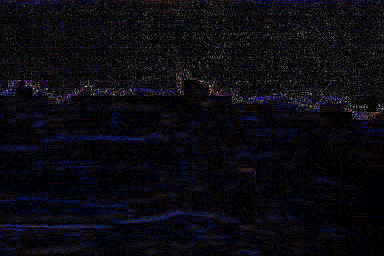

In [7]:
img_difference('../dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif', '../dataset/resaved/Tp_D_CND_M_N_ani00018_sec00096_00138resaved.jpg')

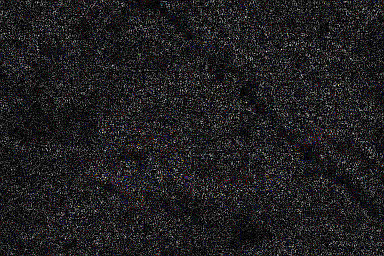

In [8]:
img_difference('../dataset/CASIA2/Au/Au_ani_00050.jpg','../dataset/resaved/Au_ani_00050resaved.jpg')

In [9]:
# divide dataset into train and test

def prep_dataset():
    X = []
    y = []
    for index, row in df.iterrows():
        x= img_difference(row['img'], row['img_resaved']).resize((128,128))
        # x= img_difference(row['img'], row['img_resaved']).resize((224,224))
        X.append(np.array(x).flatten()/255.0)
        y.append([1,0] if row['label'] == 'Au' else [0,1])
    return X, y


In [11]:
X, y = prep_dataset()

In [13]:
joblib.dump(X, 'X_90.joblib')
joblib.dump(y, 'y.joblib')

['y.joblib']

### Train-Test Split


In [2]:
# load X and y

X = joblib.load('X_90.joblib')
y = joblib.load('y.joblib')

In [3]:
from sklearn.model_selection import train_test_split
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data Generator


In [4]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = [self.X[k] for k in indexes]
        y = [self.y[k] for k in indexes]
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)

In [5]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 3)

y_train=y_train.reshape(y_train.shape[0], 2)
y_test=y_test.reshape(y_test.shape[0], 2)

In [6]:
train_data = DataGenerator(X_train, y_train)
val_data = DataGenerator(X_test, y_test)

In [7]:
import gc

del(X)
del(y)
gc.collect()

14

### Model Building


In [37]:
# custom model for image classification

def build_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

In [28]:
model = build_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 50176)            

In [34]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[cal1, cal2])
history =  history.history


Epoch 1/15
315/315 [==============================] - 9s 25ms/step - loss: 0.3810 - accuracy: 0.8355 - val_loss: 0.4179 - val_accuracy: 0.8053
Epoch 2/15
315/315 [==============================] - 8s 24ms/step - loss: 0.2950 - accuracy: 0.8794 - val_loss: 0.2848 - val_accuracy: 0.8882
Epoch 3/15
315/315 [==============================] - 8s 24ms/step - loss: 0.2507 - accuracy: 0.8886 - val_loss: 0.2475 - val_accuracy: 0.8878
Epoch 4/15
315/315 [==============================] - 7s 24ms/step - loss: 0.2394 - accuracy: 0.8935 - val_loss: 0.2606 - val_accuracy: 0.8930
Epoch 5/15
315/315 [==============================] - 8s 24ms/step - loss: 0.2146 - accuracy: 0.9034 - val_loss: 0.2345 - val_accuracy: 0.8946
Epoch 6/15
315/315 [==============================] - 8s 24ms/step - loss: 0.1957 - accuracy: 0.9087 - val_loss: 0.2396 - val_accuracy: 0.8926
Epoch 7/15
315/315 [==============================] - 8s 24ms/step - loss: 0.1849 - accuracy: 0.9125 - val_loss: 0.2479 - val_accuracy: 0.8870

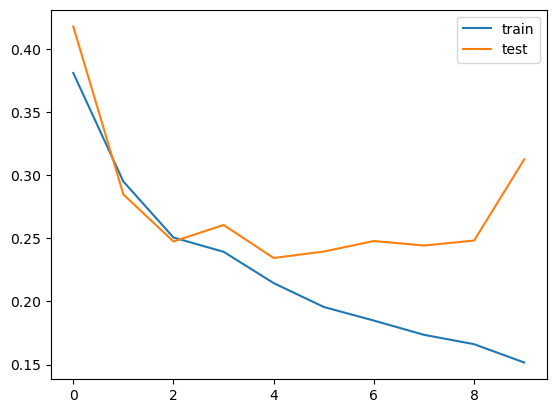

In [35]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()


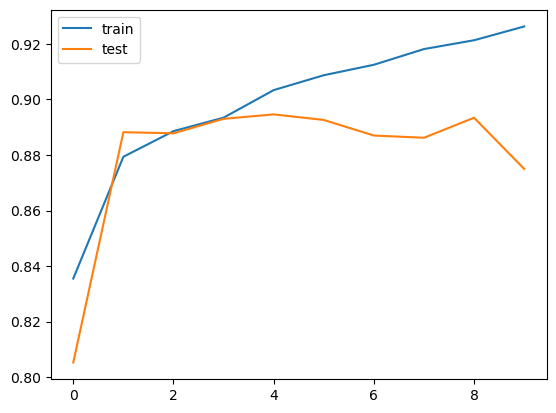

In [36]:
# plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

### VGG16 mode

In [14]:
# Vgg16 model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False


model = base_model.output
# model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)


model = Model(inputs=base_model.input, outputs=model)





In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [15]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model_vgg16.h5', monitor='val_loss', save_best_only=True)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=60, validation_data=val_data)#, callbacks=[cal1, cal2])

Epoch 1/60
315/315 [==============================] - 31s 96ms/step - loss: 0.5036 - accuracy: 0.7598 - val_loss: 0.4032 - val_accuracy: 0.8205
Epoch 2/60
315/315 [==============================] - 30s 96ms/step - loss: 0.3863 - accuracy: 0.8345 - val_loss: 0.3747 - val_accuracy: 0.8385
Epoch 3/60
315/315 [==============================] - 30s 96ms/step - loss: 0.3648 - accuracy: 0.8474 - val_loss: 0.3600 - val_accuracy: 0.8421
Epoch 4/60
315/315 [==============================] - 31s 98ms/step - loss: 0.3521 - accuracy: 0.8518 - val_loss: 0.3598 - val_accuracy: 0.8470
Epoch 5/60
315/315 [==============================] - 31s 99ms/step - loss: 0.3443 - accuracy: 0.8571 - val_loss: 0.3350 - val_accuracy: 0.8550
Epoch 6/60
315/315 [==============================] - 32s 101ms/step - loss: 0.3378 - accuracy: 0.8606 - val_loss: 0.3371 - val_accuracy: 0.8550
Epoch 7/60
315/315 [==============================] - 32s 101ms/step - loss: 0.3319 - accuracy: 0.8642 - val_loss: 0.3389 - val_accurac

In [16]:
history=history.history

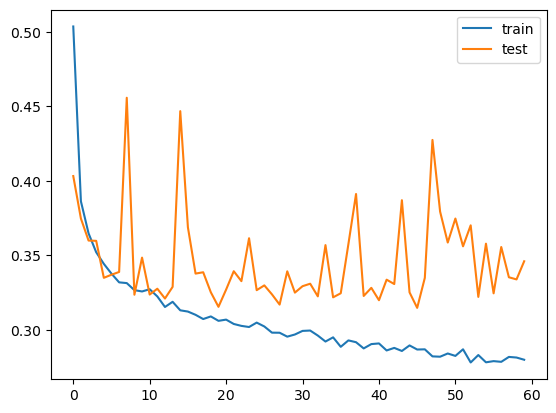

In [17]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()

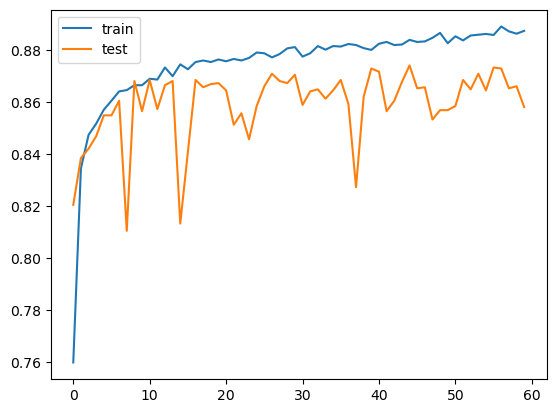

In [18]:
#  plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()


In [24]:
#  accuracy and loss for vgg16

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Xception model

In [25]:
# Xception model

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=model)



In [28]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [27]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model_xception_rms.h5', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=60, validation_data=val_data)#, callbacks=[cal1, cal2])

history=history.history


Epoch 1/60
315/315 [==============================] - 28s 82ms/step - loss: 0.3089 - accuracy: 0.8702 - val_loss: 0.3921 - val_accuracy: 0.8401
Epoch 2/60
315/315 [==============================] - 25s 81ms/step - loss: 0.2417 - accuracy: 0.8947 - val_loss: 0.3891 - val_accuracy: 0.8429
Epoch 3/60
315/315 [==============================] - 25s 81ms/step - loss: 0.2038 - accuracy: 0.9115 - val_loss: 0.5164 - val_accuracy: 0.8313
Epoch 4/60
315/315 [==============================] - 25s 81ms/step - loss: 0.1684 - accuracy: 0.9287 - val_loss: 0.6689 - val_accuracy: 0.8389
Epoch 5/60
315/315 [==============================] - 25s 81ms/step - loss: 0.1339 - accuracy: 0.9445 - val_loss: 0.5863 - val_accuracy: 0.8321
Epoch 6/60
315/315 [==============================] - 25s 81ms/step - loss: 0.1058 - accuracy: 0.9554 - val_loss: 0.9217 - val_accuracy: 0.8197
Epoch 7/60
315/315 [==============================] - 25s 81ms/step - loss: 0.0878 - accuracy: 0.9640 - val_loss: 0.7584 - val_accuracy:

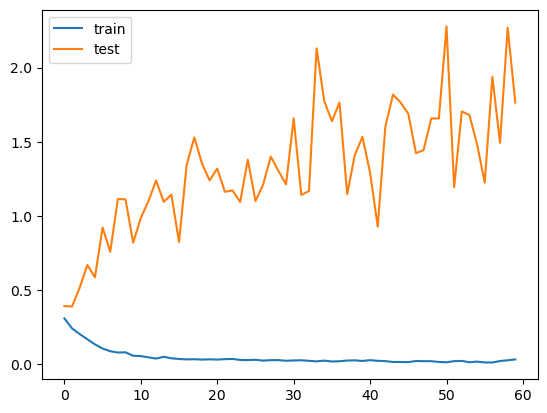

In [28]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()